In [1]:
!python -V

Python 3.11.8


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Airline-Flight-Prices-India")

<Experiment: artifact_location='/Users/l.g./Documents/Repo/ml_ops_retail_model_pipeline/model_tracking/mlruns/1', creation_time=1720060282276, experiment_id='1', last_update_time=1720060282276, lifecycle_stage='active', name='Airline-Flight-Prices-India', tags={}>

In [4]:
df = pd.read_csv('../retail_data/flight_dataset.csv')

In [5]:
df.head(n=5)

,Airline,Source,Destination,Total_Stops,Price,Date,Month,Year,Dep_hours,Dep_min,Arrival_hours,Arrival_min,Duration_hours,Duration_min
0,IndiGo,Banglore,New Delhi,0,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,2019,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,2019,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,2019,16,50,21,35,4,45


In [6]:
df.shape

(10683, 14)

In [7]:
df['SO_DE'] = df['Source'] + '_' + df['Destination']

In [8]:
categorical = ['SO_DE'] #['Source', 'Destination']
numerical = ['Duration_hours']

In [9]:
df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [11]:
dv = DictVectorizer()
X = dv.fit_transform(train_dicts)

In [12]:
target = 'Price'
y = df[target].values

In [13]:
#y_train

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training, 20% validation

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
y_pred = lr.predict(X_val)

/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_84372/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/tz/tx9cqhzx12d8m9rn6ksgbnhr0000gn/T/ipykernel_84372/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

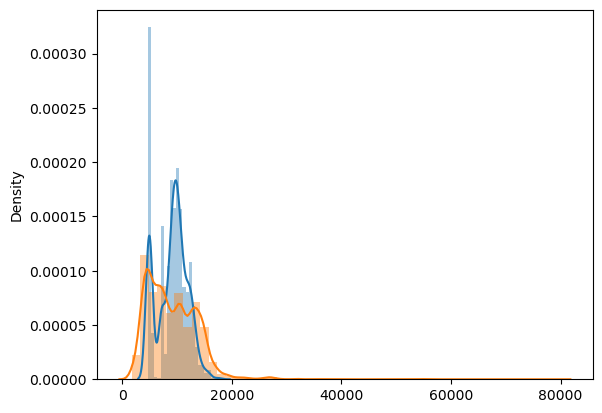

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

In [18]:
mean_squared_error(y_val, y_pred, squared=False)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3697.485935178474

In [19]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error on validation set: {rmse}")

Root Mean Squared Error on validation set: 3697.485935178474


In [20]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Lamar")

    mlflow.log_param("training-data-path", "../retail_data/flight_dataset.csv")
    mlflow.log_param("validation-data-path", "../retail_data/flight_dataset.csv")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    
    y_pred = ls.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric("rmse", rmse)

In [22]:
with open('../models/lin_lasso_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

In [23]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}



In [26]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lamdba', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3), 
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

[0]	validation-rmse:4098.07011                                                                                                                               
[1]	validation-rmse:3786.76721                                                                                                                               
[2]	validation-rmse:3600.81610                                                                                                                               
[3]	validation-rmse:3492.97167                                                                                                                               
[4]	validation-rmse:3432.21384                                                                                                                               
[5]	validation-rmse:3398.27037                                                                                                                               
[6]	validation-rmse:3379.35512                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:3361.51609                                                                                                                              
[36]	validation-rmse:3360.59506                                                                                                                              
[37]	validation-rmse:3360.68738                                                                                                                              
[38]	validation-rmse:3361.51389                                                                                                                              
[39]	validation-rmse:3360.80298                                                                                                                              
[40]	validation-rmse:3360.66922                                                                                                                              
[41]	validation-rmse:3361.25599                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3362.31666                                                                                                                              
[52]	validation-rmse:3362.01095                                                                                                                              
[53]	validation-rmse:3361.68481                                                                                                                              
[54]	validation-rmse:3361.41275                                                                                                                              
[55]	validation-rmse:3361.20673                                                                                                                              
[56]	validation-rmse:3361.01374                                                                                                                              
[57]	validation-rmse:3360.81391                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:19] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:3474.23430
[3]	validation-rmse:3404.87655                                                                                                                               
[4]	validation-rmse:3375.93747                                                                                                                               
[5]	validation-rmse:3363.54973                                                                                                                               
[6]	validation-rmse:3359.53562                                                                                                                               
[7]	validation-rmse:3357.92905                                                                                                                               
[8]	validation-rmse:3358.09201                                                                                                                               
[9]	validation-rmse:3

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[55]	validation-rmse:3360.32263                                                                                                                              
[56]	validation-rmse:3360.32263                                                                                                                              
[57]	validation-rmse:3360.32263                                                                                                                              
[58]	validation-rmse:3360.32263                                                                                                                              
[59]	validation-rmse:3360.32265                                                                                                                              
[0]	validation-rmse:4442.97372                                                                                                                               
[1]	validation-rmse:4303.02475                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:20] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[56]	validation-rmse:3359.06785                                                                                                                              
[57]	validation-rmse:3359.28263                                                                                                                              
[58]	validation-rmse:3359.49937                                                                                                                              
[59]	validation-rmse:3359.62474                                                                                                                              
[60]	validation-rmse:3359.84014                                                                                                                              
[61]	validation-rmse:3359.95873                                                                                                                              
[62]	validation-rmse:3360.13365                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3362.46764                                                                                                                              
[50]	validation-rmse:3362.46823                                                                                                                              
[51]	validation-rmse:3362.46803                                                                                                                              
[0]	validation-rmse:4348.77079                                                                                                                               
[1]	validation-rmse:4143.11032                                                                                                                               
[2]	validation-rmse:3976.74032                                                                                                                               
[3]	validation-rmse:3843.06404                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3362.96987                                                                                                                              
[53]	validation-rmse:3363.15984                                                                                                                              
[54]	validation-rmse:3363.14058                                                                                                                              
[55]	validation-rmse:3363.32092                                                                                                                              
[56]	validation-rmse:3363.59041                                                                                                                              
[57]	validation-rmse:3363.77085                                                                                                                              
[58]	validation-rmse:3362.73509                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:21] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3358.32913                                                                                                                              
[48]	validation-rmse:3358.41894                                                                                                                              
[49]	validation-rmse:3358.58334                                                                                                                              
[50]	validation-rmse:3358.67870                                                                                                                              
[51]	validation-rmse:3358.83400                                                                                                                              
[52]	validation-rmse:3358.91049                                                                                                                              
[53]	validation-rmse:3359.06568                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3358.83971                                                                                                                              
[52]	validation-rmse:3358.19234                                                                                                                              
[53]	validation-rmse:3357.62479                                                                                                                              
[54]	validation-rmse:3358.10186                                                                                                                              
[55]	validation-rmse:3357.94758                                                                                                                              
[56]	validation-rmse:3357.45285                                                                                                                              
[57]	validation-rmse:3357.91794                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[51]	validation-rmse:3360.44370                                                                                                                              
[52]	validation-rmse:3359.77451                                                                                                                              
[53]	validation-rmse:3359.68599                                                                                                                              
[54]	validation-rmse:3359.83851                                                                                                                              
[55]	validation-rmse:3358.65499                                                                                                                              
[56]	validation-rmse:3359.67058                                                                                                                              
[57]	validation-rmse:3359.83108                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:22] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3357.99557                                                                                                                              
[39]	validation-rmse:3358.10376                                                                                                                              
[40]	validation-rmse:3358.22777                                                                                                                              
[41]	validation-rmse:3358.32948                                                                                                                              
[42]	validation-rmse:3358.44223                                                                                                                              
[43]	validation-rmse:3358.62196                                                                                                                              
[44]	validation-rmse:3358.72604                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[42]	validation-rmse:3357.51176
[43]	validation-rmse:3358.16873                                                                                                                              
[44]	validation-rmse:3356.80164                                                                                                                              
[45]	validation-rmse:3357.50660                                                                                                                              
[46]	validation-rmse:3358.06412                                                                                                                              
[47]	validation-rmse:3357.65798                                                                                                                              
[48]	validation-rmse:3357.86596                                                                                                                              
[49]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3366.34008                                                                                                                              
[51]	validation-rmse:3366.37728                                                                                                                              
[52]	validation-rmse:3366.43437                                                                                                                              
[0]	validation-rmse:4245.27595                                                                                                                               
[1]	validation-rmse:3984.28213                                                                                                                               
[2]	validation-rmse:3794.56795                                                                                                                               
[3]	validation-rmse:3659.40746                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:3548.41137                                                                                                                               
[1]	validation-rmse:3369.32964                                                                                                                               
[2]	validation-rmse:3350.66020                                                                                                                               
[3]	validation-rmse:3350.43015                                                                                                                               
[4]	validation-rmse:3351.29001                                                                                                                               
[5]	validation-rmse:3355.02510                                                                                                                               
[6]	validation-rmse:3358.04586                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[50]	validation-rmse:3356.59954                                                                                                                              
[51]	validation-rmse:3356.18728                                                                                                                              
[52]	validation-rmse:3356.89872                                                                                                                              
[0]	validation-rmse:4432.20526                                                                                                                               
[1]	validation-rmse:4283.95647                                                                                                                               
[2]	validation-rmse:4154.08854                                                                                                                               
[3]	validation-rmse:4040.71692                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[56]	validation-rmse:3358.63382                                                                                                                              
[57]	validation-rmse:3358.76196                                                                                                                              
[58]	validation-rmse:3358.84623                                                                                                                              
[59]	validation-rmse:3358.96578                                                                                                                              
[60]	validation-rmse:3359.03808                                                                                                                              
[61]	validation-rmse:3359.16513                                                                                                                              
[62]	validation-rmse:3359.29046                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3357.97171                                                                                                                              
[50]	validation-rmse:3357.87150                                                                                                                              
[51]	validation-rmse:3357.89138                                                                                                                              
[52]	validation-rmse:3357.83420                                                                                                                              
[53]	validation-rmse:3357.88702                                                                                                                              
[54]	validation-rmse:3357.86763                                                                                                                              
[55]	validation-rmse:3357.94755                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[48]	validation-rmse:3360.44518                                                                                                                              
[49]	validation-rmse:3360.09094                                                                                                                              
[50]	validation-rmse:3359.79179                                                                                                                              
[51]	validation-rmse:3359.53967                                                                                                                              
[52]	validation-rmse:3359.33045                                                                                                                              
[53]	validation-rmse:3359.16612                                                                                                                              
[54]	validation-rmse:3359.03011                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[43]	validation-rmse:3356.46210                                                                                                                              
[44]	validation-rmse:3356.86009                                                                                                                              
[45]	validation-rmse:3356.46077                                                                                                                              
[46]	validation-rmse:3356.51964                                                                                                                              
[47]	validation-rmse:3357.14243                                                                                                                              
[48]	validation-rmse:3356.68494                                                                                                                              
[49]	validation-rmse:3356.79023                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[65]	validation-rmse:3353.11971                                                                                                                              
[66]	validation-rmse:3353.34773                                                                                                                              
[67]	validation-rmse:3353.35494                                                                                                                              
[68]	validation-rmse:3352.40861                                                                                                                              
[0]	validation-rmse:4269.08576                                                                                                                               
[1]	validation-rmse:4020.45824                                                                                                                               
[2]	validation-rmse:3837.00769                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[78]	validation-rmse:3347.63076                                                                                                                              
[0]	validation-rmse:4295.72141                                                                                                                               
[1]	validation-rmse:4060.64993                                                                                                                               
[2]	validation-rmse:3881.95052                                                                                                                               
[3]	validation-rmse:3746.22327                                                                                                                               
[4]	validation-rmse:3645.49557                                                                                                                               
[5]	validation-rmse:3569.72597                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[78]	validation-rmse:3344.84931                                                                                                                              
[0]	validation-rmse:4318.90074                                                                                                                               
[1]	validation-rmse:4094.85777                                                                                                                               
[2]	validation-rmse:3919.33202                                                                                                                               
[3]	validation-rmse:3782.56146                                                                                                                               
[4]	validation-rmse:3677.05498                                                                                                                               
[5]	validation-rmse:3596.39784                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[38]	validation-rmse:3361.45977                                                                                                                              
[39]	validation-rmse:3361.73786                                                                                                                              
[40]	validation-rmse:3362.09312                                                                                                                              
[41]	validation-rmse:3362.61900                                                                                                                              
[42]	validation-rmse:3363.10445                                                                                                                              
[43]	validation-rmse:3363.58107                                                                                                                              
[44]	validation-rmse:3362.42219                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:26] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3359.34620                                                                                                                              
[50]	validation-rmse:3359.36109                                                                                                                              
[51]	validation-rmse:3359.51453                                                                                                                              
[52]	validation-rmse:3359.17428                                                                                                                              
[53]	validation-rmse:3359.52565                                                                                                                              
[54]	validation-rmse:3359.54941                                                                                                                              
[55]	validation-rmse:3359.50093                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4148.71709                                                                                                                               
[1]	validation-rmse:3849.61367                                                                                                                               
[2]	validation-rmse:3657.51814                                                                                                                               
[3]	validation-rmse:3537.17180                                                                                                                               
[4]	validation-rmse:3463.34906                                                                                                                               
[5]	validation-rmse:3418.74561                                                                                                                               
[6]	validation-rmse:3392.27079                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[53]	validation-rmse:3360.32288                                                                                                                              
[54]	validation-rmse:3360.32292                                                                                                                              
[55]	validation-rmse:3360.32297                                                                                                                              
[56]	validation-rmse:3360.32302                                                                                                                              
[57]	validation-rmse:3360.32303                                                                                                                              
[58]	validation-rmse:3360.32303                                                                                                                              
[59]	validation-rmse:3360.32306                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:27] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3355.55206                                                                                                                              
[48]	validation-rmse:3355.53883                                                                                                                              
[49]	validation-rmse:3355.49459                                                                                                                              
[50]	validation-rmse:3355.48673                                                                                                                              
[51]	validation-rmse:3355.45412                                                                                                                              
[52]	validation-rmse:3355.20560                                                                                                                              
[53]	validation-rmse:3355.49423                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:3384.15138
[8]	validation-rmse:3371.91018                                                                                                                               
[9]	validation-rmse:3365.09159                                                                                                                               
[10]	validation-rmse:3360.43172                                                                                                                              
[11]	validation-rmse:3358.03337                                                                                                                              
[12]	validation-rmse:3356.52929                                                                                                                              
[13]	validation-rmse:3355.50652                                                                                                                              
[14]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[67]	validation-rmse:3358.41971
[68]	validation-rmse:3358.31911                                                                                                                              
[69]	validation-rmse:3358.58489                                                                                                                              
[70]	validation-rmse:3358.59381                                                                                                                              
[71]	validation-rmse:3358.47008                                                                                                                              
[0]	validation-rmse:4390.56946                                                                                                                               
[1]	validation-rmse:4212.31020                                                                                                                               
[2]	validation-rmse:

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:28] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[56]	validation-rmse:3357.53323                                                                                                                              
[57]	validation-rmse:3357.30962                                                                                                                              
[58]	validation-rmse:3357.75696                                                                                                                              
[59]	validation-rmse:3357.06290                                                                                                                              
[60]	validation-rmse:3357.55843                                                                                                                              
[61]	validation-rmse:3357.65202                                                                                                                              
[62]	validation-rmse:3358.01102                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[72]	validation-rmse:3359.09195                                                                                                                              
[73]	validation-rmse:3360.05141                                                                                                                              
[74]	validation-rmse:3359.51126                                                                                                                              
[75]	validation-rmse:3359.67760                                                                                                                              
[76]	validation-rmse:3359.19036                                                                                                                              
[77]	validation-rmse:3359.42999                                                                                                                              
[78]	validation-rmse:3359.35395                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:4459.36484                                                                                                                               
[1]	validation-rmse:4332.21474                                                                                                                               
[2]	validation-rmse:4218.21332                                                                                                                               
[3]	validation-rmse:4116.14163                                                                                                                               
[4]	validation-rmse:4025.14380                                                                                                                               
[5]	validation-rmse:3944.02953                                                                                                                               
[6]	validation-rmse:3872.03955                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[49]	validation-rmse:3358.11152                                                                                                                              
[50]	validation-rmse:3357.78541                                                                                                                              
[51]	validation-rmse:3357.85107                                                                                                                              
[52]	validation-rmse:3357.45656                                                                                                                              
[53]	validation-rmse:3357.04444                                                                                                                              
[54]	validation-rmse:3357.37325                                                                                                                              
[55]	validation-rmse:3357.60590                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[47]	validation-rmse:3360.24214                                                                                                                              
[48]	validation-rmse:3360.25325                                                                                                                              
[49]	validation-rmse:3360.26291                                                                                                                              
[50]	validation-rmse:3360.27119                                                                                                                              
[51]	validation-rmse:3360.27846                                                                                                                              
[52]	validation-rmse:3360.28462                                                                                                                              
[53]	validation-rmse:3360.28997                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[57]	validation-rmse:3357.82592                                                                                                                              
[58]	validation-rmse:3357.86683                                                                                                                              
[59]	validation-rmse:3357.94148                                                                                                                              
[0]	validation-rmse:4144.96542                                                                                                                               
[1]	validation-rmse:3845.36713                                                                                                                               
[2]	validation-rmse:3653.90088                                                                                                                               
[3]	validation-rmse:3534.60262                      

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3360.47886                                                                                                                              
[53]	validation-rmse:3360.32609                                                                                                                              
[54]	validation-rmse:3360.48661                                                                                                                              
[55]	validation-rmse:3360.08127                                                                                                                              
[56]	validation-rmse:3359.90213                                                                                                                              
[57]	validation-rmse:3360.04860                                                                                                                              
[58]	validation-rmse:3359.65303                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[76]	validation-rmse:3346.69227                                                                                                                              
[77]	validation-rmse:3346.67882                                                                                                                              
[78]	validation-rmse:3346.52843                                                                                                                              
[79]	validation-rmse:3345.76255                                                                                                                              
[80]	validation-rmse:3345.35996                                                                                                                              
[81]	validation-rmse:3345.38249                                                                                                                              
[82]	validation-rmse:3344.68202                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[52]	validation-rmse:3350.47349
[53]	validation-rmse:3350.26262                                                                                                                              
[54]	validation-rmse:3350.04108                                                                                                                              
[55]	validation-rmse:3349.91786                                                                                                                              
[56]	validation-rmse:3349.87852                                                                                                                              
[57]	validation-rmse:3349.88263                                                                                                                              
[58]	validation-rmse:3349.93794                                                                                                                              
[59]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[53]	validation-rmse:3359.22411                                                                                                                              
[54]	validation-rmse:3359.25699                                                                                                                              
[55]	validation-rmse:3359.32109                                                                                                                              
[56]	validation-rmse:3359.76594                                                                                                                              
[57]	validation-rmse:3360.11425                                                                                                                              
[58]	validation-rmse:3360.53558                                                                                                                              
[59]	validation-rmse:3360.84256                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[64]	validation-rmse:3359.59612                                                                                                                              
[65]	validation-rmse:3359.64608                                                                                                                              
[66]	validation-rmse:3359.97279                                                                                                                              
[67]	validation-rmse:3359.91711                                                                                                                              
[68]	validation-rmse:3360.06566                                                                                                                              
[69]	validation-rmse:3360.22361                                                                                                                              
[70]	validation-rmse:3360.16712                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[57]	validation-rmse:3355.30501                                                                                                                              
[58]	validation-rmse:3355.08643                                                                                                                              
[59]	validation-rmse:3355.30805                                                                                                                              
[60]	validation-rmse:3355.09744                                                                                                                              
[61]	validation-rmse:3355.30180                                                                                                                              
[62]	validation-rmse:3355.33221                                                                                                                              
[63]	validation-rmse:3355.30181                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:3540.68204
[19]	validation-rmse:3521.73953                                                                                                                              
[20]	validation-rmse:3504.53794                                                                                                                              
[21]	validation-rmse:3489.09398                                                                                                                              
[22]	validation-rmse:3475.09075                                                                                                                              
[23]	validation-rmse:3462.54383                                                                                                                              
[24]	validation-rmse:3451.17922                                                                                                                              
[25]	validation-rmse

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:4244.39461
[2]	validation-rmse:4102.74084                                                                                                                               
[3]	validation-rmse:3981.70536                                                                                                                               
[4]	validation-rmse:3878.73128                                                                                                                               
[5]	validation-rmse:3791.47889                                                                                                                               
[6]	validation-rmse:3717.83021                                                                                                                               
[7]	validation-rmse:3655.88402                                                                                                                               
[8]	validation-rmse:3

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[61]	validation-rmse:3359.62628                                                                                                                              
[62]	validation-rmse:3359.87950                                                                                                                              
[63]	validation-rmse:3359.13818                                                                                                                              
[64]	validation-rmse:3359.37419                                                                                                                              
[65]	validation-rmse:3359.64947                                                                                                                              
[66]	validation-rmse:3359.62986                                                                                                                              
[67]	validation-rmse:3359.79154                     

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:3639.06045                                                                                                                               
[10]	validation-rmse:3597.62971                                                                                                                              
[11]	validation-rmse:3561.95302                                                                                                                              
[12]	validation-rmse:3531.29116                                                                                                                              
[13]	validation-rmse:3504.99039                                                                                                                              
[14]	validation-rmse:3482.47013                                                                                                                              
[15]	validation-rmse:3462.96885                     

In [30]:
params = {
'learning_rate': 0.05059823075449685,
'max_depth': 4,
'min_child_weight':5.008520794187583,
'objective':'reg:linear',
'reg_alpha':0.07415085063191965,
'reg_lambda':0.11333795232359768,
'seed':42
}
mlflow.xgboost.autolog()

booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
        )

2024/07/05 20:50:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd314532b18cb434aaab184dd17828c01', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:4494.41195
[1]	validation-rmse:4396.23220
[2]	validation-rmse:4305.84720
[3]	validation-rmse:4222.61594
[4]	validation-rmse:4146.18900
[5]	validation-rmse:4076.09819
[6]	validation-rmse:4011.93263
[7]	validation-rmse:3953.14508
[8]	validation-rmse:3899.24441
[9]	validation-rmse:3850.15363
[10]	validation-rmse:3805.21178
[11]	validation-rmse:3764.20674
[12]	validation-rmse:3726.96975
[13]	validation-rmse:3692.79540
[14]	validation-rmse:3661.88846
[15]	validation-rmse:3633.85200
[16]	validation-rmse:3608.30752
[17]	validation-rmse:3584.84806
[18]	validation-rmse:3563.32215
[19]	validation-rmse:3543.69828
[20]	validation-rmse:3526.11281
[21]	validation-rmse:3509.65330
[22]	validation-rmse:3495.42546
[23]	validation-rmse:3482.67046
[24]	validation-rmse:3470.17495
[25]	validation-rmse:3459.62301
[26]	validation-rmse:3449.32536
[27]	validation-rmse:3440.65329
[28]	validation-rmse:3431.98008
[29]	validation-rmse:3424.10006
[30]	validation-rmse:3417.01574
[31]	validation-rm

/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:50:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[71]	validation-rmse:3345.15262
[72]	validation-rmse:3344.44240
[73]	validation-rmse:3344.13405
[74]	validation-rmse:3343.56702
[75]	validation-rmse:3343.49459
[76]	validation-rmse:3342.98582
[77]	validation-rmse:3342.50116
[78]	validation-rmse:3342.07453
[79]	validation-rmse:3341.71972
[80]	validation-rmse:3341.49136
[81]	validation-rmse:3341.39766
[82]	validation-rmse:3341.18391
[83]	validation-rmse:3341.03579
[84]	validation-rmse:3340.81810
[85]	validation-rmse:3340.59438
[86]	validation-rmse:3340.56805
[87]	validation-rmse:3340.57758
[88]	validation-rmse:3340.53650
[89]	validation-rmse:3340.35847
[90]	validation-rmse:3340.30784
[91]	validation-rmse:3340.32196
[92]	validation-rmse:3340.09744
[93]	validation-rmse:3339.94983
[94]	validation-rmse:3339.75099
[95]	validation-rmse:3339.63619
[96]	validation-rmse:3339.71473
[97]	validation-rmse:3339.24598
[98]	validation-rmse:3339.07356
[99]	validation-rmse:3338.97820
[100]	validation-rmse:3338.58949
[101]	validation-rmse:3338.57103
[102]	

2024/07/05 20:50:14 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/07/05 20:50:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/ml_ops_env/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:50:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
